https://www.quantstart.com/articles/aluminum-smelting-cointegration-strategy-in-qstrader

In [14]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts

import datetime
import matplotlib.dates as mdates
import pprint

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

In [4]:
def long_only_sharpe(col, risk_free_rate=0.04):
    dr_col = col.pct_change()
    edr_col= dr_col - risk_free_rate / 252.0
    return annualised_sharpe(edr_col)

In [20]:
def market_neutral_sharpe(tick, benchmark):
    col1 = tick['Close'].pct_change()
    col2 = benchmark['Close'].pct_change()

    diff_pd = pd.DataFrame(index=tick.index)
    diff_pd['net_ret'] = (col1 - col2) / 2.0

    return annualised_sharpe(diff_pd['net_ret'])

In [6]:
def net_ret(tick):
    return tick.pct_change()

In [7]:
start = dt.datetime(2004, 11, 18)
end = dt.datetime(2007, 11, 30)
gld  = data.DataReader('GLD', 'google', start, end)
gdx = data.DataReader('GDX', 'google', start, end)
spy = data.DataReader('SPY', 'google', start, end)

In [8]:
gld.head()

,Open,High,Low,Close,Volume
Date,,,,,
2004-11-18,44.43,44.49,44.07,44.38,5991500
2004-11-19,44.49,44.92,44.47,44.78,11655000
2004-11-22,44.75,44.97,44.74,44.95,11995600
2004-11-23,44.88,44.92,44.72,44.75,3169000
2004-11-24,44.93,45.05,44.79,45.05,6105100


In [9]:
gld.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2007-11-26,82.25,82.25,81.13,81.30,6769500
2007-11-27,80.70,80.89,79.81,80.10,6626800
2007-11-28,79.42,79.87,78.76,79.57,9030500
2007-11-29,79.28,79.33,78.28,78.28,8647800
2007-11-30,78.35,78.60,76.98,77.32,7872100


In [10]:
gdx.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-22,36.52,37.29,35.87,37.23,197100
2006-05-23,37.75,39.22,37.75,37.96,620900
2006-05-24,37.13,37.57,35.87,36.52,638600
2006-05-25,37.18,38.32,36.98,38.32,366800
2006-05-26,38.74,38.74,37.77,38.55,269400


In [11]:
gdx.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2007-11-26,49.43,49.43,46.85,47.06,1955100
2007-11-27,46.84,46.84,45.74,46.61,2321000
2007-11-28,46.11,48.00,46.06,47.86,2891000
2007-11-29,47.10,48.00,46.76,47.02,1665900
2007-11-30,47.09,47.50,45.70,46.36,2001100


In [12]:
print market_neutral_sharpe(gdx, spy)
print market_neutral_sharpe(gld, spy)

0.291597518071
0.593187318047


In [13]:
print long_only_sharpe(gdx['Close'])
print long_only_sharpe(gld['Close'])

0.471083092975
0.869831454447


In [14]:
def measure_drawdowns(daily_returns):

    cumret = np.cumprod(1 + daily_returns) - 1
    
    hwm = [0] # High Watermark
    eq_idx = cumret.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        hwm.append(max(hwm[t-1], cumret[t]))
        drawdown[t]= (1 + hwm[t]) / (1 + cumret[t]) - 1
        if drawdown[t] <= 0:
            duration[t]= 0
        else:
            duration[t] = duration[t-1] + 1
    return drawdown.max(), duration.max()


In [15]:
measure_drawdowns(net_ret(gdx['Close']))

(0.25821876867901916, 117.0)

In [21]:
def test_cointegration(sym1, sym2, start, end):
    s1 = data.DataReader(sym1, 'google', start, end)
    s2 = data.DataReader(sym2, 'google', start, end)

    s1['Key'] = s1.index
    s2['Key'] = s2.index

    merged = pd.merge(s1, s2, on='Key')

    x1 = merged['Close_x']
    x2 = merged['Close_y']
    
    coint_result = ts.coint(x1, x2) 
    return coint_result

In [28]:
def test_correlation(sym1, sym2, start, end):
    s1 = data.DataReader(sym1, 'google', start, end)
    s2 = data.DataReader(sym2, 'google', start, end)
 
    s1['Key'] = s1.index
    s2['Key'] = s2.index

    merged = pd.merge(s1, s2, on='Key')
    new = pd.DataFrame(index=merged.index)
    new['X'] = merged['Close_x']
    new['Y'] = merged['Close_y']

    beta, alpha = np.polyfit(new['X'], new['Y'], 1)
    return beta, alpha, new.corr(method='pearson')


In [ ]:
start = dt.datetime(2004, 11, 18)
end = dt.datetime(2007, 11, 30)

In [23]:
test_cointegration('GLD', 'GDX', start, end)

(-3.6048336753923791,
 0.024166194822750238,
 array([-3.44740523, -2.86905694, -2.57077435]))

In [24]:
test_cointegration('CRM', 'NOW', start, end)

(-3.7876105744707225,
 0.014080083730920933,
 array([-3.49614905, -2.89032096, -2.58212235]))

In [25]:
test_cointegration('MSFT', 'SPY', start, end)

(-2.1301985652441942,
 0.46059524596968199,
 array([-3.43893823, -2.86533046, -2.56878843]))

In [26]:
test_cointegration('MSFT', 'CRM', start, end)

(-2.6965075065227846,
 0.20083728549481022,
 array([-3.43893823, -2.86533046, -2.56878843]))

In [30]:
b, a, c = test_correlation('GLD', 'GDX', start, end)
print "Beta", b
print "Alpha", a
print c

Beta 0.607320108047
Alpha 0.156633044494
          X         Y
X  1.000000  0.918347
Y  0.918347  1.000000


In [32]:
start = dt.datetime(2014, 11, 18)
end = dt.datetime(2016, 11, 30)

print test_cointegration('CRM', 'NOW', start, end)
b, a, c = test_correlation('CRM', 'NOW', start, end)
print "Beta", b
print "Alpha", a
print c

(-2.1891570962039837, 0.42996182000714633, array([-3.44316155, -2.8671905 , -2.5697795 ]))
Beta 0.487302930514
Alpha 38.7381419733
          X         Y
X  1.000000  0.432563
Y  0.432563  1.000000


In [33]:
start = dt.datetime(2014, 11, 18)
end = dt.datetime(2016, 11, 30)

print test_cointegration('GLD', 'GDX', start, end)
b, a, c = test_correlation('GLD', 'GDX', start, end)
print "Beta", b
print "Alpha", a
print c

(-3.1579755333292843, 0.077241337920649869, array([-3.44316155, -2.8671905 , -2.5697795 ]))
Beta 0.631185252145
Alpha -52.8392634405
          X         Y
X  1.000000  0.953412
Y  0.953412  1.000000


# Hedge Ratio

In [6]:
def plot_price_series(df, ts1, ts2):
    months = mdates.MonthLocator() # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
    ax.grid(True)
    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()

In [7]:
def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()

In [8]:
def plot_residuals(df):
    months = mdates.MonthLocator() # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label="Residuals")
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
    ax.grid(True)
    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()
    plt.plot(df["res"])
    plt.show()

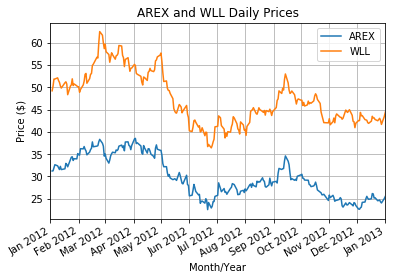

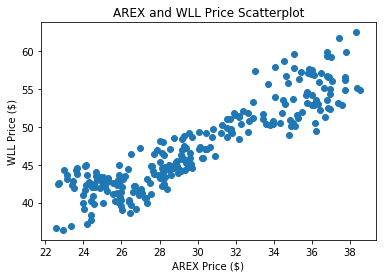

In [19]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2013, 1, 1)
arex = data.DataReader("AREX", 'yahoo', start, end)
wll = data.DataReader("WLL", 'yahoo', start, end)
df = pd.DataFrame(index=arex.index)
df["AREX"] = arex["Adj Close"]
df["WLL"] = wll["Adj Close"]

# Plot the two time series
plot_price_series(df, "AREX", "WLL")

# Display a scatter plot of the two time series
plot_scatter_series(df, "AREX", "WLL")

In [20]:
import statsmodels.formula.api as sm
res = ts.coint(df['WLL'], df["AREX"])
print res

(-2.9337691516636255, 0.12679976147849925, array([-3.94078403, -3.36067957, -3.06145832]))
